In [3]:
import pandas as pd
import glob
import re
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import gridspec
from scipy.special import comb
import arcadia_pycolor as apc


In [4]:
apc.mpl.setup()

In [5]:
def harvest_mod_outputs(path, file_pattern, output_filename=None):
    """
    Processes files in a directory matching a pattern, extracts parameters from filenames,
    and creates subplots comparing linear vs neural correlations by QTL parameter.

    Args:
        path: String path to the directory containing files
        file_pattern: String pattern for glob to match files (e.g., 'qhaplo_*qtl_*marker_*n_rep*_*.csv')
        output_filename: Optional filename for saving the plot (default: 'correlation_comparison.png')

    Returns:
        DataFrame: Combined dataframe of all processed files
        Figure: Matplotlib figure object for further customization if needed
    """
    # Get all files that match the pattern
    csv_files = glob.glob(os.path.join(path, file_pattern))

    if not csv_files:
        print(f"No files found matching pattern '{file_pattern}' in '{path}'")
        return None, None

    # Create an empty list to store individual dataframes
    dfs = []

    # Process each file
    for file in csv_files:
        # Extract the filename from the path
        filename = os.path.basename(file)

        # Extract parameters using regex
        qtl_match = re.search(r'(\d+)qtl', filename)
        n_match = re.search(r'(\d+)n', filename)
        rep_match = re.search(r'rep(\d+)', filename)

        if qtl_match and n_match and rep_match:
            qtl_value = int(qtl_match.group(1))
            n_value = int(n_match.group(1))
            rep_value = int(rep_match.group(1))

                # Read the CSV file
            df = pd.read_csv(file)

            # Add columns for the parameters
            df['qtl_param'] = qtl_value
            df['n_param'] = n_value
            df['rep'] = rep_value

            # Add the dataframe to our list
            dfs.append(df)
        else:
            print(f"Couldn't extract parameters from {filename}")

    # Combine all dataframes into one
    if dfs:
        outdf = pd.concat(dfs, ignore_index=True)

        # Display the first few rows of the combined dataframe
        print(outdf.head())

    else:
        print("No matching files found or parameters couldn't be extracted")
    return outdf

In [6]:
linear_df = harvest_mod_outputs('./gplinear', 'qhaplo_*qtl_*n_rep*_phenotype_correlations_untuned.csv')
neural_df = harvest_mod_outputs('./gpnet', 'qhaplo_*qtl_*n_rep*_phenotype_correlations_untuned.csv')


   trait_number  pearson_correlation  p_value  true_mean  pred_mean  true_std  \
0             1             0.998541      0.0  -0.005308   0.005000  0.999202   
1             2             0.896942      0.0  -0.002408  -0.016737  1.007783   
2             3             0.677698      0.0  -0.003273  -0.004532  0.998969   
3             4             0.550198      0.0   0.002280   0.017836  0.996942   
4             5             0.360087      0.0  -0.005150  -0.005316  1.000086   

   pred_std trait_architecture  qtl_param  n_param  rep  
0  0.769702                1-5       2002   100000    2  
1  0.530100                1-5       2002   100000    2  
2  0.357462                1-5       2002   100000    2  
3  0.282274                1-5       2002   100000    2  
4  0.189693                1-5       2002   100000    2  
   trait_number  pearson_correlation  true_mean  pred_mean  true_std  \
0             1             0.997797  -0.005308  -0.253626  0.999201   
1             2      

In [7]:
def get_parameter_combinations(df1, df2):
    # Get all unique combinations from both dataframes
    params1 = df1[['qtl_param', 'n_param', 'trait_number', 'rep']].drop_duplicates()
    params2 = df2[['qtl_param', 'n_param', 'trait_number', 'rep']].drop_duplicates()

    # Find common combinations using merge
    common_params = pd.merge(params1, params2, on=['qtl_param', 'n_param', 'trait_number', 'rep'])

    return common_params

In [8]:
common_params = get_parameter_combinations(linear_df, neural_df)


In [9]:
def generate_comparison_df(df1, df2, common_params):
    """
    Generates paired comparison dataframe from two input dataframes that contain prediciton results from different models

    Args: The two dataframes to compare, and common param combinations
    Returns: Single dataframe with paired up outputs
    """
    comparison_data = []

    for _, row in common_params.iterrows():
        qtl = row['qtl_param']
        n = row['n_param']
        trait = row['trait_number']
        rep = row['rep']

        linear_row = df1[(df1['qtl_param'] == qtl) &
                            (df1['n_param'] == n) &
                            (df1['trait_number'] == trait) &
                            (df1['rep'] == rep)]

        neural_row = df2[(df2['qtl_param'] == qtl) &
                            (df2['n_param'] == n) &
                            (df2['trait_number'] == trait)&
                            (df2['rep'] == rep)]

        if not linear_row.empty and not neural_row.empty:
            comparison_data.append({
                'qtl_param': qtl,
                'n_param': n,
                'trait_number': trait,
                'rep': rep,
                'linear_correlation': linear_row['pearson_correlation'].values[0],
                'neural_correlation': neural_row['pearson_correlation'].values[0],
                'difference': (neural_row['pearson_correlation'].values[0] - linear_row['pearson_correlation'].values[0])/linear_row['pearson_correlation'].values[0]
            })

    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df


In [10]:
comparison_df = generate_comparison_df(linear_df, neural_df, common_params)


In [11]:
comparison_df

,qtl_param,n_param,trait_number,rep,linear_correlation,neural_correlation,difference
0,2002,100000,1,2,0.998541,0.997797,-0.000744
1,2002,100000,2,2,0.896942,0.886550,-0.011586
2,2002,100000,3,2,0.677698,0.657882,-0.029241
3,2002,100000,4,2,0.550198,0.517199,-0.059977
4,2002,100000,5,2,0.360087,0.334804,-0.070212
...,...,...,...,...,...,...,...
1395,1002,1000000,1,1,0.999400,0.999458,0.000058
1396,1002,1000000,2,1,0.909765,0.953043,0.047571
1397,1002,1000000,3,1,0.694123,0.887865,0.279117
1398,1002,1000000,4,1,0.582456,0.858307,0.473600


In [12]:
def plot_difference_scatter(comparison_df):
    """
    Creates a scatter plot with fitted splines showing the difference between neural and linear models,
    with QTL number on x-axis (log scaled) and difference on y-axis.
    Points and splines are colored by sample size.
    """

    # Get unique traits and sample sizes
    unique_traits = sorted(comparison_df['trait_number'].unique())
    unique_n = sorted(comparison_df['n_param'].unique())

    num_traits = len(unique_traits)

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_traits, figsize=(5*num_traits, 6), sharey=False)  # Changed sharey to False

    # If there's only one trait, axes won't be an array
    if num_traits == 1:
        axes = [axes]

    # Create a colormap for sample sizes
    cmap = apc.gradients.viridis.to_mpl_cmap()
    colors = cmap(np.linspace(0, 1, len(unique_n)))

    # Define Va/Vg values for each subplot
    va_vg_values = [1, 0.8, 0.5, 0.3, 0.15]

    # Define custom y-limits for each subplot if needed
    # You can customize these values based on your data
    y_limits = [
        (-0.25, 0.5),     # for the first subplot
        (-0.25, 0.5),   # for the second subplot
        (-1, 2),     # for the third subplot
        (-1.25, 2.5),   # for the fourth subplot
        (-1.5, 3)      # for the fifth subplot
    ]

    for i, trait in enumerate(unique_traits):
        # Filter data for this trait
        trait_data = comparison_df[comparison_df['trait_number'] == trait]

        # For each sample size, plot points and fit a smoother curve
        for j, n in enumerate(unique_n):
            # Filter data for this sample size
            n_data = trait_data[trait_data['n_param'] == n]

            # Sort by QTL parameter for proper fitting
            n_data = n_data.sort_values('qtl_param')

            # Extract x and y data
            x_data = n_data['qtl_param'].values
            y_data = n_data['difference'].values

            # Plot the scatter points
            axes[i].scatter(x_data, y_data, color=colors[j], s=50, alpha=0.9)

            # Only proceed if we have enough data points
            if len(x_data) >= 4:
                # Use log of x for fitting to handle the log scale properly
                log_x = np.log10(x_data)

                # Fit a smoother spline with regularization
                # Adjust smoothing factor s to control how closely the curve follows points
                s = len(x_data) * 25.5  # Adjust this value as needed
                try:
                    spline = UnivariateSpline(log_x, y_data, s=s)

                    # Create smooth points for plotting
                    log_x_smooth = np.linspace(min(log_x), max(log_x), 100)
                    y_smooth = spline(log_x_smooth)

                    # Convert back to original scale for plotting
                    x_smooth = 10**log_x_smooth

                    # Plot the smoothed line
                    axes[i].plot(x_smooth, y_smooth, '-', color=colors[j],
                                linewidth=2, label=f'{n}' if i == 0 else "")
                except Exception:
                    # If spline fitting fails, use a simpler approach
                    # Just connect the points with straight lines
                    axes[i].plot(x_data, y_data, '-', color=colors[j], alpha=0.5,
                                linewidth=1.5, label=f'{n}' if i == 0 else "")

        # Set x-axis to log scale
        axes[i].set_xscale('log')

        # Add a horizontal line at y=0
        axes[i].axhline(y=0, color='gray', linestyle='--', alpha=0.7)

        # Set title and labels with Va/Vg value
        # Make sure i is within the range of va_vg_values
        va_vg_value = va_vg_values[i] if i < len(va_vg_values) else f"Trait {trait}"
        axes[i].set_title(r'$V_A/V_G = %s$' % va_vg_value)
        axes[i].set_xlabel('QTL# (log scale)')

        if i == 0:
            axes[i].set_ylabel('Difference (MLP - Linear)')

        # Set custom y-axis limits for each subplot
        # Make sure i is within the range of y_limits
        if i < len(y_limits):
            axes[i].set_ylim(y_limits[i])
        else:
            # Fallback to automatic limits based on data if no custom limit defined
            y_max = max(1, abs(trait_data['difference']).max() * 1.1)  # At least 1, or 10% padding
            axes[i].set_ylim(-1, y_max)

    # Add legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.005),
              ncol=len(unique_n), title="Sample Size")

    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Adjust layout for suptitle and legend

    return fig, axes

## Figure 1A.

(<Figure size 1800x432 with 5 Axes>,
 array([<Axes: title={'center': '$V_A/V_G = 1$'}, xlabel='QTL# (log scale)', ylabel='Difference (MLP - Linear)'>,
        <Axes: title={'center': '$V_A/V_G = 0.8$'}, xlabel='QTL# (log scale)'>,
        <Axes: title={'center': '$V_A/V_G = 0.5$'}, xlabel='QTL# (log scale)'>,
        <Axes: title={'center': '$V_A/V_G = 0.3$'}, xlabel='QTL# (log scale)'>,
        <Axes: title={'center': '$V_A/V_G = 0.15$'}, xlabel='QTL# (log scale)'>],
       dtype=object))

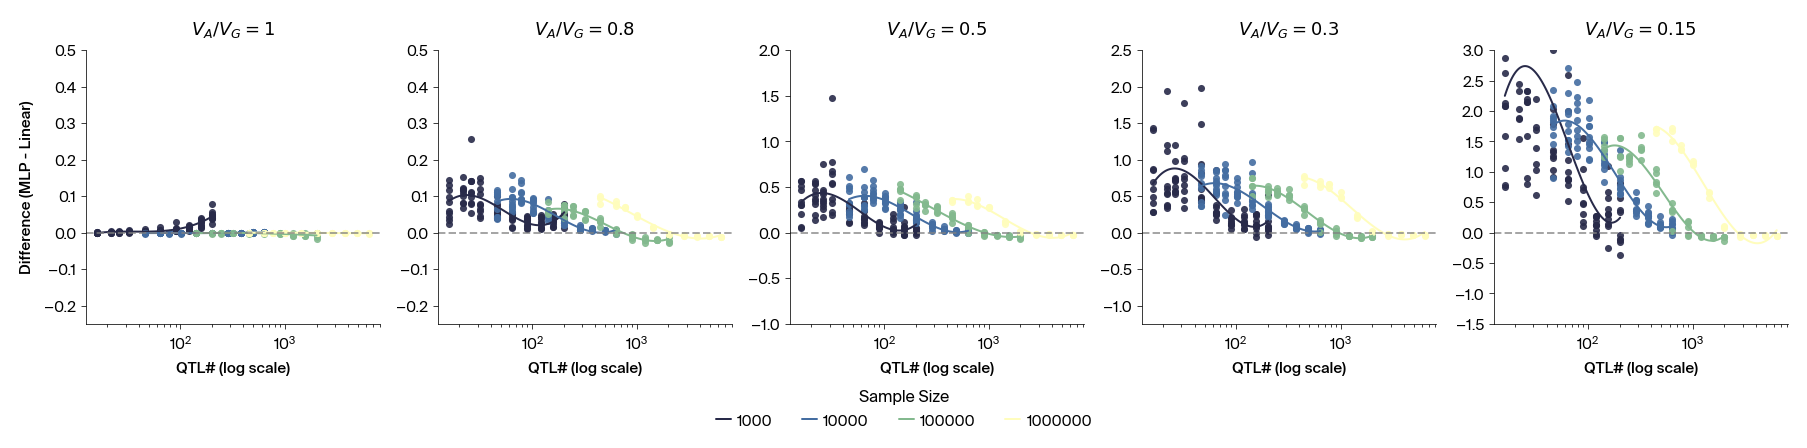

In [13]:
plot_difference_scatter(comparison_df)

In [14]:
def plot_correlation_scatter(comparison_df, correlation_type='neural_correlation'):
    """
    Creates a scatter plot with fitted splines showing the specified correlation type,
    with QTL number on x-axis (log scaled) and correlation on y-axis.
    Points and splines are colored by sample size.

    Parameters:
    -----------
    comparison_df : pandas DataFrame
        The data frame containing the correlation data
    correlation_type : str, optional
        The type of correlation to plot. Default is 'neural_correlation'
        Options: 'neural_correlation', 'linear_correlation', 'difference'
    """

    # Validate correlation type
    valid_types = ['neural_correlation', 'linear_correlation', 'difference']
    if correlation_type not in valid_types:
        raise ValueError(f"correlation_type must be one of {valid_types}")

    # Set the appropriate title and y-line based on correlation type
    if correlation_type == 'neural_correlation':
        plot_title = 'Neural Network Performance by Trait'
        y_line = 0.6  # Example threshold line
        y_label = 'Pearsons r'
    elif correlation_type == 'linear_correlation':
        plot_title = 'Linear Model Performance by Trait'
        y_line = 0.6  # Example threshold line
        y_label = 'Pearsons r'
    else:  # 'difference'
        plot_title = 'Neural Network vs Linear Model Performance Difference by Trait'
        y_line = 0  # Zero line for difference
        y_label = 'Difference (Neural - Linear)'

    # Get unique traits and sample sizes
    unique_traits = sorted(comparison_df['trait_number'].unique())
    unique_n = sorted(comparison_df['n_param'].unique())

    num_traits = len(unique_traits)

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_traits, figsize=(5*num_traits, 6), sharey=False)

    # If there's only one trait, axes won't be an array
    if num_traits == 1:
        axes = [axes]

    # Create a colormap for sample sizes
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(unique_n)))

    for i, trait in enumerate(unique_traits):
        # Filter data for this trait
        trait_data = comparison_df[comparison_df['trait_number'] == trait]

        # For each sample size, plot points and fit a smoother curve
        for j, n in enumerate(unique_n):
            # Filter data for this sample size
            n_data = trait_data[trait_data['n_param'] == n]

            # Sort by QTL parameter for proper fitting
            n_data = n_data.sort_values('qtl_param')

            # Extract x and y data
            x_data = n_data['qtl_param'].values
            y_data = n_data[correlation_type].values

            # Plot the scatter points
            axes[i].scatter(x_data, y_data, color=colors[j], s=50, alpha=0.7)

            # Only proceed if we have enough data points
            if len(x_data) >= 4:
                # Use log of x for fitting to handle the log scale properly
                log_x = np.log10(x_data)

                # Fit a smoother spline with regularization
                # Adjust smoothing factor s to control how closely the curve follows points
                s = len(x_data) * 0.1  # Adjust this value as needed
                try:
                    spline = UnivariateSpline(log_x, y_data, s=s)

                    # Create smooth points for plotting
                    log_x_smooth = np.linspace(min(log_x), max(log_x), 100)
                    y_smooth = spline(log_x_smooth)

                    # Convert back to original scale for plotting
                    x_smooth = 10**log_x_smooth

                    # Plot the smoothed line
                    axes[i].plot(x_smooth, y_smooth, '-', color=colors[j],
                                linewidth=2, label=f'{n}' if i == 0 else "")
                except Exception:
                    # If spline fitting fails, use a simpler approach
                    # Just connect the points with straight lines
                    axes[i].plot(x_data, y_data, '-', color=colors[j], alpha=0.5,
                                linewidth=1.5, label=f'{n}' if i == 0 else "")

        # Set x-axis to log scale
        axes[i].set_xscale('log')

        # Add a reference line
        axes[i].axhline(y=y_line, color='gray', linestyle='--', alpha=0.7)

        # Set title and labels
        axes[i].set_title(f'Trait {trait}')
        axes[i].set_xlabel('QTL Number (log scale)')

        if i == 0:
            axes[i].set_ylabel(y_label)

        # Set y-axis limits based on correlation type
        if correlation_type == 'difference':
            y_max = abs(comparison_df[correlation_type]).max() * 1.1
            axes[i].set_ylim(-y_max, y_max)
        else:
            axes[i].set_ylim(0, 1.1)

    # Add legend with better positioning to avoid overlap
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05),
              ncol=min(len(unique_n), 4), title="Sample Size")

    plt.suptitle(plot_title, fontsize=16)
    plt.tight_layout(rect=[0, 0.1, 1, 0.93])  # Adjusted to leave room for legend at bottom


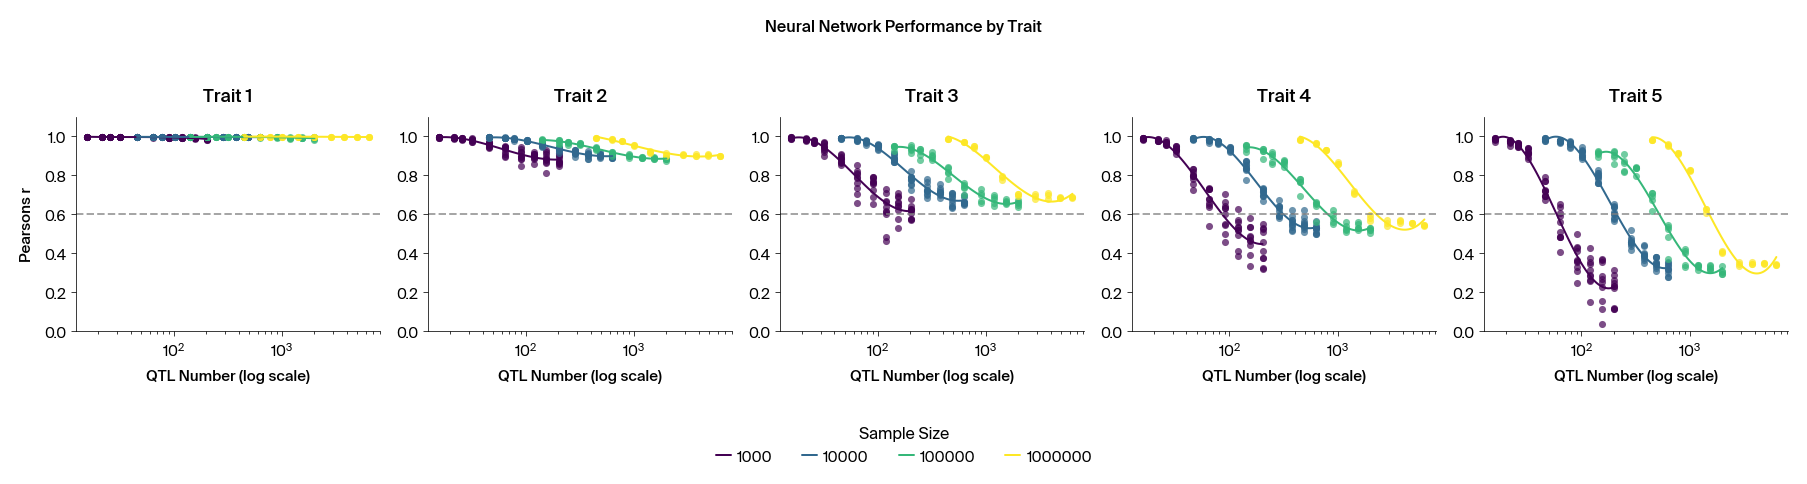

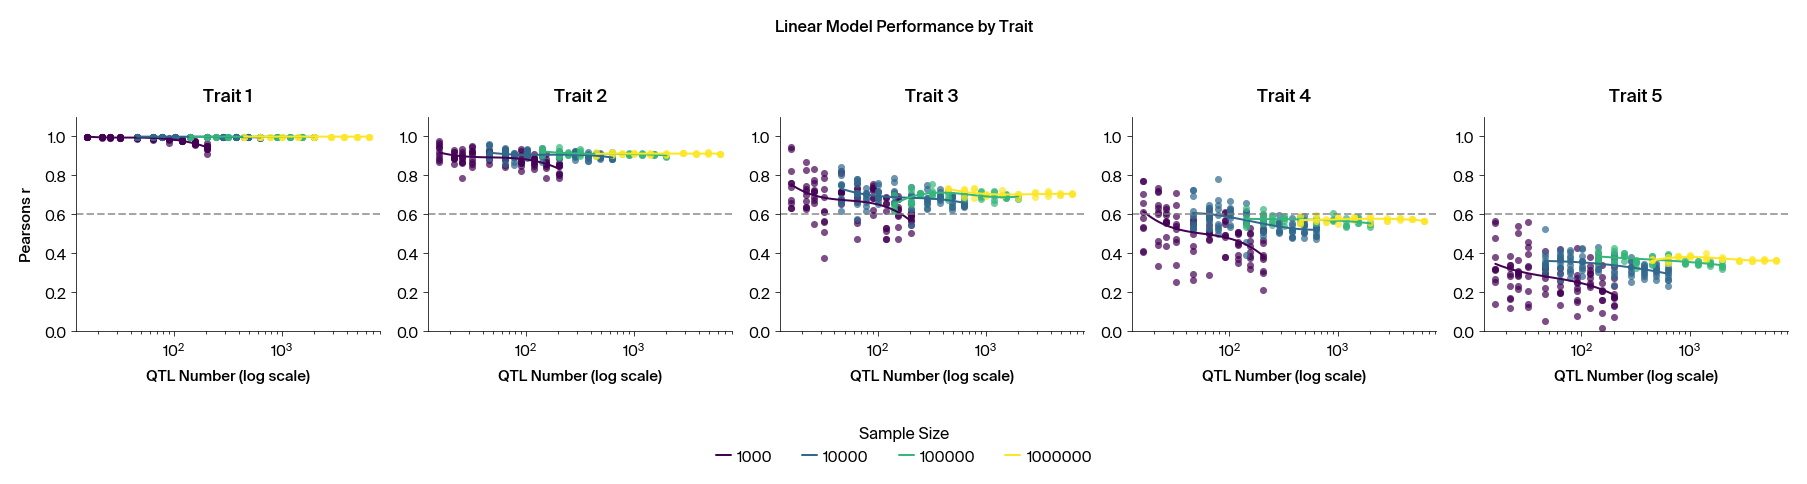

In [15]:
plot_correlation_scatter(comparison_df)
plot_correlation_scatter(comparison_df, correlation_type='linear_correlation')


## Figure 1B.

   qtl_param  n_param  trait_number  rep  linear_correlation  \
0       2002   100000             1    2            0.998541   
1       2002   100000             2    2            0.896942   
2       2002   100000             3    2            0.677698   
3       2002   100000             4    2            0.550198   
4       2002   100000             5    2            0.360087   

   neural_correlation  difference  scaled_qtl_n      log_N  
0            0.997797   -0.000744      20.03001  11.512925  
1            0.886550   -0.011586      20.03001  11.512925  
2            0.657882   -0.029241      20.03001  11.512925  
3            0.517199   -0.059977      20.03001  11.512925  
4            0.334804   -0.070212      20.03001  11.512925  


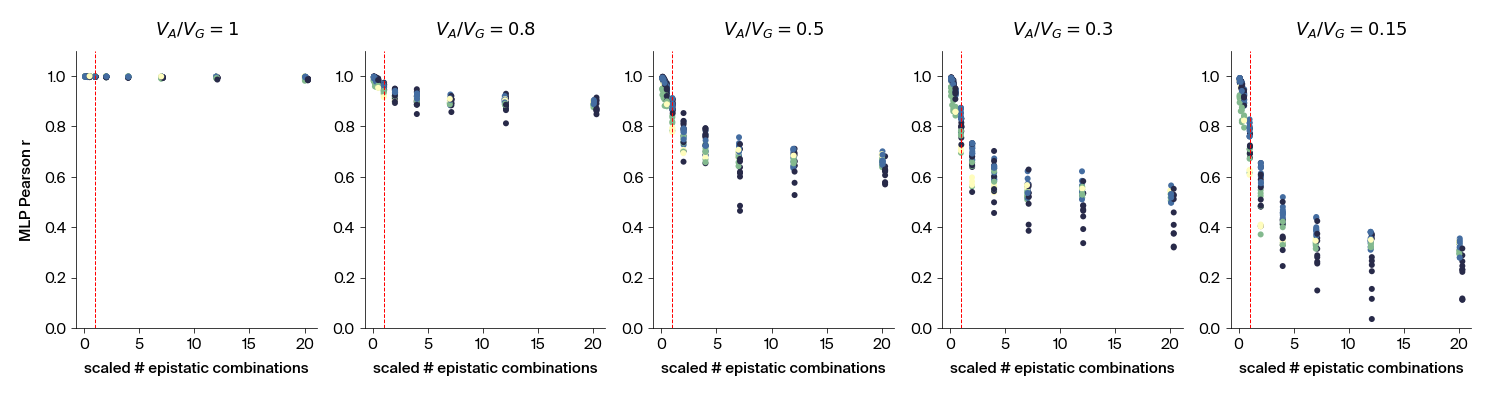

In [16]:

combination_values = []
for value in comparison_df['qtl_param']:
    combination_values.append(comb(value, 2))

comparison_df['scaled_qtl_n'] = combination_values/comparison_df['n_param']

comparison_df['log_N'] = np.log(comparison_df['n_param'])

print(comparison_df.head())

# Get unique trait numbers
unique_traits = sorted(comparison_df['trait_number'].unique())
num_traits = len(unique_traits)

# Create figure with subplots
fig = plt.figure(figsize=(5*num_traits, 5))
gs = gridspec.GridSpec(1, num_traits)

    # Create a colormap for sample sizes
#cmap = apc.gradients.viridis.to_mpl_cmap()
#colors = cmap(np.linspace(0, 1, len(unique_n)))

# Define Va/Vg values for each subplot
va_vg_values = [1, 0.8, 0.5, 0.3, 0.15]

# Create a subplot for each trait_number
for i, trait_num in enumerate(unique_traits):
    ax = plt.subplot(gs[i])

    # Filter data for current trait number
    trait_data = comparison_df[comparison_df['trait_number']==trait_num]

    # Create scatter plot with same parameters as your original
    scatter = ax.scatter(trait_data['scaled_qtl_n'], trait_data['neural_correlation'],
                         c=trait_data['log_N'], cmap=apc.gradients.viridis.to_mpl_cmap())

    # Set consistent y-limits
    ax.set_ylim(0, 1.1)
    ax.grid(False)

    # Add vertical line at x=1
    ax.axvline(x=1, color='r', linestyle='--', linewidth=1)

    # Set labels
    ax.set_xlabel('scaled # epistatic combinations')
    if i == 0:
        ax.set_ylabel('MLP Pearson r')

    # Add title for each subplot
    va_vg_value = va_vg_values[i] if i < len(va_vg_values) else f"Trait {trait_num}"
    ax.set_title(r'$V_A/V_G = %s$' % va_vg_value)
